In [1]:
import torch 
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])
train_dataset = torchvision.datasets.MNIST(root = './data', train = True , download = True , transform = transform)
train_loader = DataLoader(train_dataset,batch_size = 128, shuffle = True)

100%|██████████████████████████████████████████████████████████████████████████████| 9.91M/9.91M [00:13<00:00, 759kB/s]
100%|██████████████████████████████████████████████████████████████████████████████| 28.9k/28.9k [00:00<00:00, 391kB/s]
100%|█████████████████████████████████████████████████████████████████████████████| 1.65M/1.65M [00:01<00:00, 1.34MB/s]
100%|█████████████████████████████████████████████████████████████████████████████| 4.54k/4.54k [00:00<00:00, 4.89MB/s]


In [5]:
class Generator(nn.Module):
    def __init__(self,noise_dim,img_dim):
        super(Generator,self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim,256),
            nn.ReLU(True),
            nn.Linear(256,512),
            nn.ReLU(True),
            nn.Linear(512,1024),
            nn.ReLU(True),
            nn.Linear(1024,img_dim),
            nn.Tanh()
        )
    def forward(self,z):
        return self.model(z)

In [10]:
class Discriminator(nn.Module):
    def __init__(self,img_dim):
        super(Discriminator,self).__init__()
        self.model = nn.Sequential(
            nn.Linear(img_dim,512),
            nn.LeakyReLU(0.2,inplace = True),
            nn.Linear(512,1024),
            nn.LeakyReLU(0.2,inplace = True),
            nn.Linear(1024,256),
            nn.LeakyReLU(0.2,inplace = True),
            nn.Linear(256,1),
            nn.Sigmoid()
        )
    def forward(self,img):
        return self.model(img)
        
        

In [22]:
noise_dim = 100
img_dim = 28 * 28

generator = Generator(noise_dim,img_dim).to(device)
discriminator = Discriminator(img_dim).to(device)

g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)

criterion = nn.BCELoss()

In [23]:
def show_generated_images(epoch,generator,fixed_noise):
    generator.eval()
    with torch.no_grad():
        fake_imgs = generator(fixed_noise).reshape(-1,1,28,28)
        fake_imgs = fake_imgs * 0.5 + 0.5 # Denormalize
    grid = torchvision.utils.make_grid(fake_imgs,nrow = 8)
    plt.figure(figsize = (8,8))
    plt.imshow(grid.permute(1,2,0).cpu().numpy())
    plt.title(f'generated images at epoch {epoch}')
    plt.axis('off')
    plt.show()
    generator.train()


In [24]:
def train_gan(train_loader,num_epochs,mode = "one_one"):
    fixed_noise = torch.randn(64,noise_dim).to(device) # For consistent evaluation
    for epoch in range(num_epochs):
        for batch_idx , (real,_) in enumerate(train_loader):
            batch_size = real.size(0)
            real = real.view(batch_size,-1).to(device)

            # Create real and fake labels
            real_labels = torch.ones(batch_size,1).to(device)
            fake_labels = torch.zeros(batch_size,1).to(device)

            ########################### Train discriminator ##################################################
            #Real Images
            outputs = discriminator(real)
            d_loss_real = criterion(outputs,real_labels)
            real_score = outputs
            #Fake Images
            z = torch.randn(batch_size,noise_dim).to(device)
            fake = generator(z)
            outputs = discriminator(fake.detach())
            d_loss_fake = criterion(outputs,fake_labels)
            fake_score = outputs

            # Total discriminator loss
            d_loss = d_loss_real + d_loss_fake

            discriminator.zero_grad()
            d_loss.backward()
            d_optimizer.step()

            ################################ Train Generator #############################################
            z = torch.randn(batch_size,noise_dim).to(device)
            fake = generator(z)
            outputs = discriminator(fake)

            g_loss = criterion(outputs,real_labels)

            generator.zero_grad()
            g_loss.backward()
            g_optimizer.step()

            ################################### Modify according to mode #######################################

            if mode == "five_gen_one_disc":
                for _ in range(4):  # already did 1 step above
                    z = torch.randn(batch_size, noise_dim).to(device)
                    fake = generator(z)
                    outputs = discriminator(fake)
                    g_loss = criterion(outputs, real_labels)

                    generator.zero_grad()
                    g_loss.backward()
                    g_optimizer.step()

            if mode == "five_disc_one_gen":
                for _ in range(4):  # already did 1 step above
                    # Real
                    outputs = discriminator(real)
                    d_loss_real = criterion(outputs, real_labels)

                    # Fake
                    z = torch.randn(batch_size, noise_dim).to(device)
                    fake = generator(z)
                    outputs = discriminator(fake.detach())
                    d_loss_fake = criterion(outputs, fake_labels)

                    d_loss = d_loss_real + d_loss_fake

                    discriminator.zero_grad()
                    d_loss.backward()
                    d_optimizer.step()
                    
        if (epoch+1) % 10 ==0 :
            print(f"Epoch [{epoch+1}/{num_epochs}], D_loss: {d_loss.item():.4f}, G_loss: {g_loss.item():.4f}")
            show_generated_images(epoch+1, generator, fixed_noise)
            

Training: 1-step Gen, 1-step Disc
Epoch [10/50], D_loss: 0.0000, G_loss: 64.9036


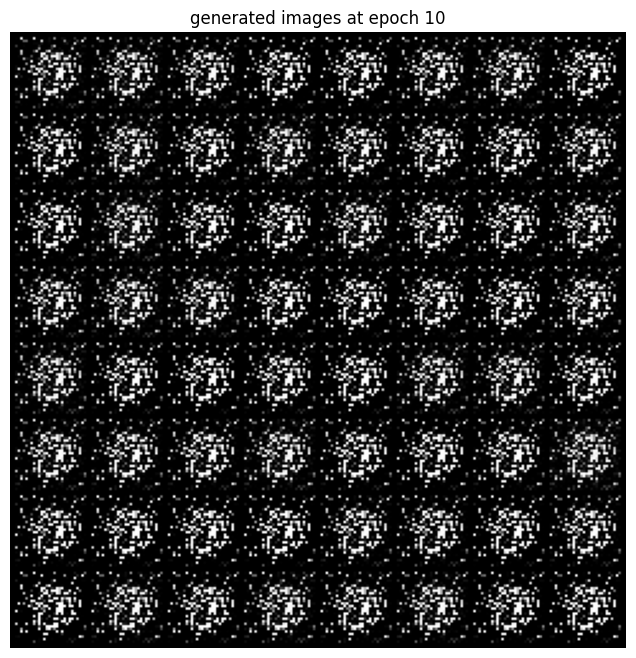

Epoch [20/50], D_loss: 0.0000, G_loss: 64.1836


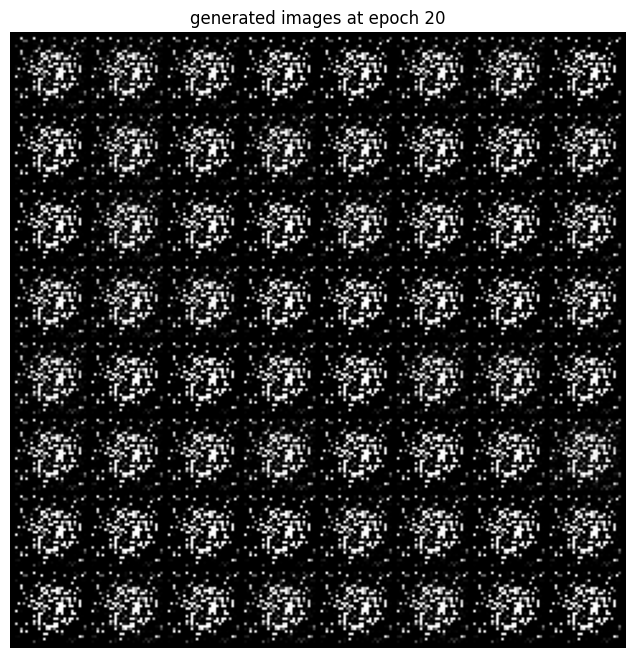

Epoch [30/50], D_loss: 0.0000, G_loss: 62.3909


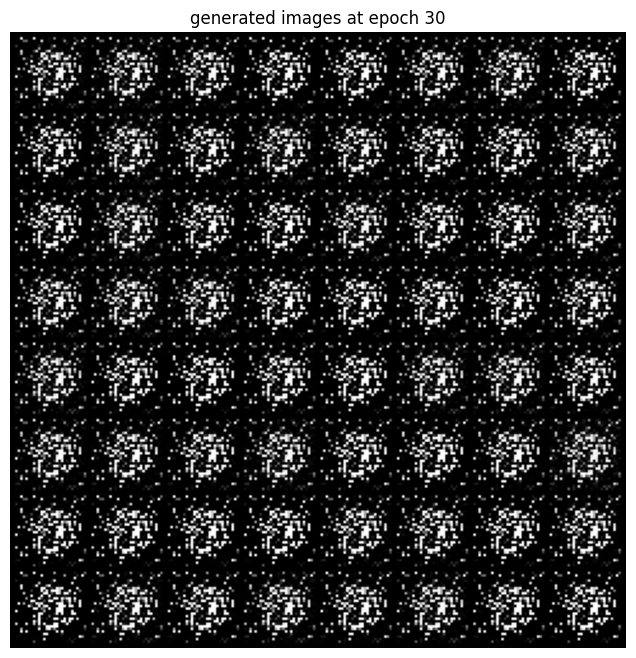

Epoch [40/50], D_loss: 0.0000, G_loss: 60.4367


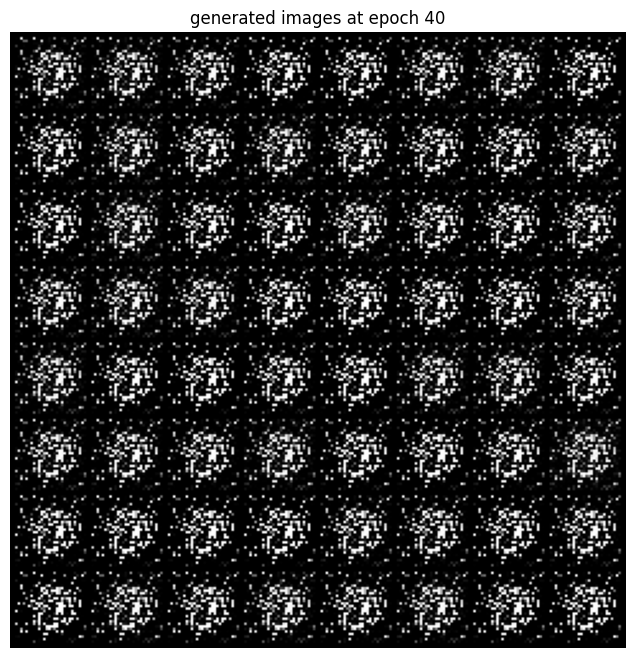

Epoch [50/50], D_loss: 0.0000, G_loss: 65.2548


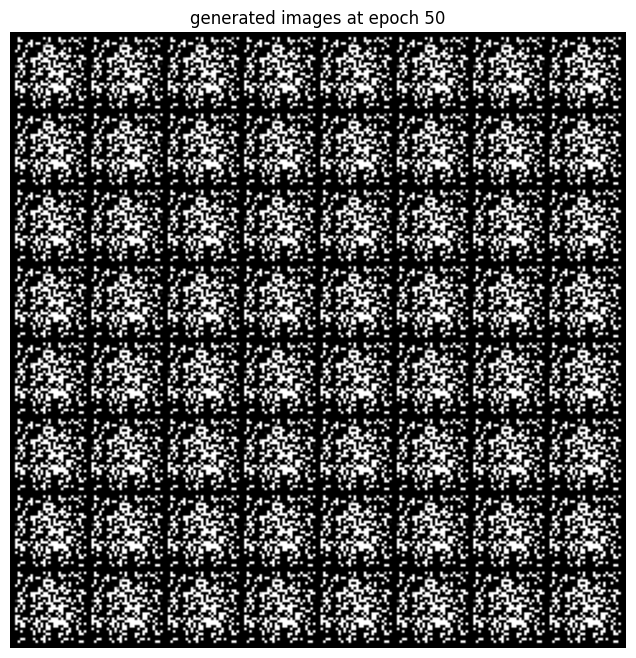

Training: 5-step Gen, 1-step Disc
Epoch [10/50], D_loss: 0.0000, G_loss: 62.7542


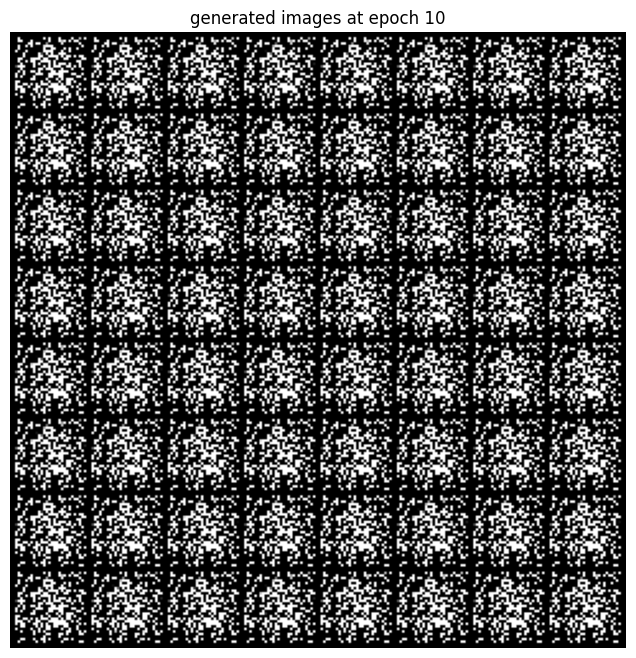

KeyboardInterrupt: 

In [25]:

# 1. Standard: One step Generator, One step Discriminator
print("Training: 1-step Gen, 1-step Disc")
train_gan(train_loader, num_epochs=50, mode="one_one")

# 2. 5 Generator steps, 1 Discriminator step
print("Training: 5-step Gen, 1-step Disc")
train_gan(train_loader, num_epochs=50, mode="five_gen_one_disc")

# 3. 5 Discriminator steps, 1 Generator step
print("Training: 5-step Disc, 1-step Gen")
train_gan(train_loader, num_epochs=50, mode="five_disc_one_gen")
     